In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout
import os, io,zipfile
from PIL import Image
import tqdm
import cv2
from pathlib import Path

In [7]:
# load data - data has training (tumor,no-tumor) and test (tumor,no-tumor) datasets

zip_file_path=("/content/MRIBrainTumor.zip")
extracted_dir=("/content/extracted_data")
!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [46]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# path_to_no_tumor_directory and "path_to_pituitary_tumor_directory"
no_tumor_path = Path("/content/extracted_data/Training/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Training/pituitary_tumor")

images = []  # List for images
labels = []  # Each time load the image and put in image array, add labels 1 tumor / 0 no-tumor to the labels array

for img_path in no_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')  # Load img from disk - load img files' contents to memory
    img_array = image.img_to_array(img)  # Convert img to list of images

    images.append(img_array)  # Add img to list of images
    labels.append(0)  # For each not-tumor: value is 0

for img_path in pituitary_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')  # Load img from disk - load img files' contents to memory
    img_array = image.img_to_array(img)  # Convert img to list of images
    images.append(img_array)  # Add img to list of images
    labels.append(1)  # For each tumor: value is 1

# create a single numpy array (not a python list) with all the images we loaded
x_train=np.array(images)
#convert labels to a numpy array
y_train=np.array(labels)


In [41]:
x_train.shape  #(1222, 224, 224, 1)
#y_train.shape #(1222,)

(1222, 224, 224, 1)

In [42]:
pd.Series(y_train).value_counts()

1    827
0    395
dtype: int64

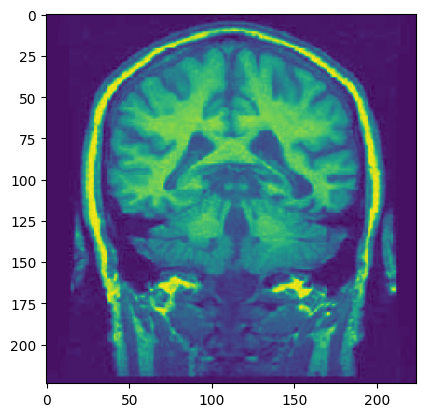

In [44]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

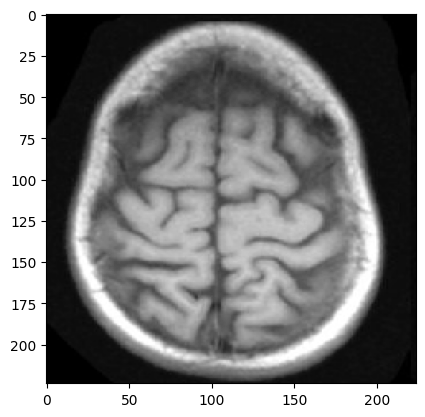

In [47]:
plt.imshow(x_train[1],cmap='gray')

In [77]:
# x_train is a 4D array representing images : (1222, 224, 224, 1) (num_images,height,width,channel)
# for traditionl ML shoulr reshape x to a 2D array where each row contains all the pixel values of one image
x_train_updated=x_train.reshape(len(x_train),-1)
x_train_updated.shape # (1222, 50176)   224*224


(1222, 50176)

In [86]:
# split data
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x_train_updated,y_train,random_state=10,test_size=0.2)
xtrain.shape  # (977, 50176)
ytrain.shape  # (977,)
xtest.shape  # (245, 50176)
ytest.shape  # (245,)



(245,)

In [80]:
xtest.min(), xtest.max(),

(0.0, 255.0)

In [81]:
# feature scaling  between 0 to 1
xtrain=xtrain.astype('float32')
xtest=xtest.astype("float32")
xtrain/=255
xtest/=255
print(xtrain.min(), xtrain.max())
print(xtest.min(), xtest.max())

0.0 1.0
0.0 1.0


In [99]:
# Train Model
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(C=0.1)  # C is penalty parameter
lg.fit(xtrain, ytrain)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier()

In [100]:
# Evaluation
print("Training score rf:", rf.score(xtrain, ytrain))
print("Testing score rf:", rf.score(xtest, ytest))
print("Training score lg:", lg.score(xtrain, ytrain))
print("Testing score lg:", lg.score(xtest, ytest))


Training score rf: 1.0
Testing score rf: 0.9795918367346939
Training score lg: 1.0
Testing score lg: 0.9306122448979591


In [101]:
# prediction
pred=lg.predict(xtest)
np.where(ytest!=pred) # predicted and actual are not same : misclassified

(array([ 12,  16,  20,  28,  32,  51,  55,  57,  73,  87,  89, 149, 153,
        172, 210, 229, 239]),)

In [102]:
ytest[12]

0

In [103]:
pred[12]

1

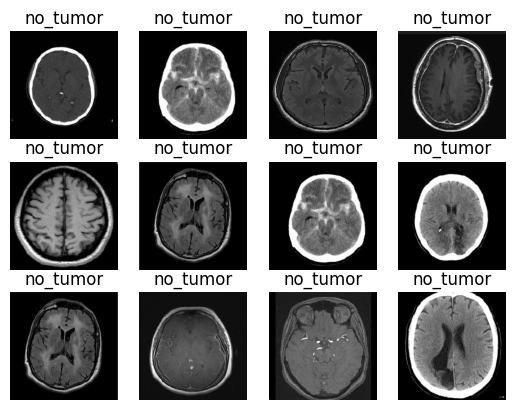

In [153]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Test Model
class_labels = ["no_tumor", "tumor"]

# Path to directories containing images
p=Path("/content/extracted_data/Testing")
no_tumor_path = Path("/content/extracted_data/Testing/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Testing/pituitary_tumor")

# Plot images
c = 1
for img_path in no_tumor_path.glob("*jpg"):
    if c > 12:  # Break out of loop if more than 16 images are plotted
        break
    plt.subplot(3, 4, c)
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    img_array = image.img_to_array(img) # Convert image to array
    img_array = img_array.reshape(1, -1) / 255 # Reshape to have correct dimensions # rows and 224x224 columns
    p = rf.predict(img_array)
    plt.title(class_labels[p[0]])  # Use predicted label
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1
plt.show()


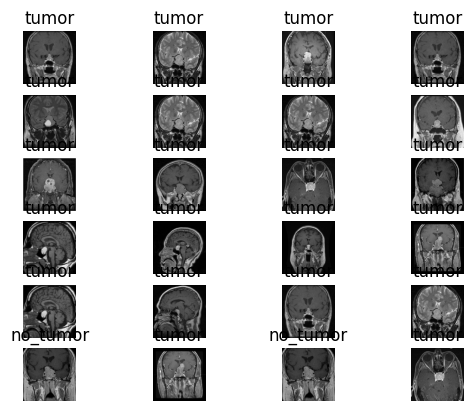

In [156]:
# Plot images
c = 1
for img_path in pituitary_tumor_path.glob("*jpg"):
    if c > 24:  # Break out of loop if more than 16 images are plotted
        break
    plt.subplot(6, 4, c)
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    img_array = image.img_to_array(img)  # Convert image to array and scale
    img_array = img_array.reshape(1, -1) /255 # Reshape to have correct dimensions
    p = lg.predict(img_array)
    plt.title(class_labels[p[0]])  # Use predicted label
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1
plt.show()  # some are misclassified
